# level of analysis : inter subjects

In [7]:

def load_tfr(pid, ch_name, version ):
    """
    Load time-frequency representation (TFR) data using MNE.

    Parameters:
    pid (str): Participant ID.
    ch_name (str): Channel name.

    Returns:
    epochTFR (mne.time_frequency.EpochsTFR or None): The loaded TFR data. Returns None if the file is not found.
    """
    tfr_path = os.path.join(base_TF_path, pid, f'powerLF_{version}_{ch_name}.h5')
    if os.path.isfile(tfr_path):
        epochTFR = mne.time_frequency.read_tfrs(tfr_path)
        return epochTFR
    else:
        print(f'TFR file not found for {pid} - {ch_name}')
        return None


def compute_diff_average_tfr(epochTFR, condition1_trial, condition2_trial):
    """
    Compute the difference in average TFR between two conditions.

    Parameters:
    epochTFR (mne.time_frequency.EpochsTFR): The TFR data.
    condition1_trial (list of int): Indices of trials for condition 1.
    condition2_trial (list of int): Indices of trials for condition 2.

    Returns:
    diff_data (numpy.ndarray): The difference in average TFR between the two conditions.
    c1_data (numpy.ndarray): The log-transformed TFR data for condition 1.
    c2_data (numpy.ndarray): The log-transformed TFR data for condition 2.
    """
    c1_data = np.log10(epochTFR.data[condition1_trial].squeeze())
    c2_data = np.log10(epochTFR.data[condition2_trial].squeeze())
    c1_data_av = np.mean(c1_data, axis=0)
    c2_data_av = np.mean(c2_data, axis=0)
    diff_data = c1_data_av - c2_data_av
    return diff_data


def combine_layer(row, version = 'raw'):

    
    pid = row['pid']
    layer_names=['layer1','layer2','layer4','layer5','layer6']

    
    path_epoch_quality = f'/mnt/data/AdaptiveControl/IBLrawdata/TF_data/{pid}/epoch_quality_{version}.csv'

    quality_data = pd.read_csv(path_epoch_quality)

    bad_trials = quality_data[(quality_data['skewness'] > 1.5) | (quality_data['max_power'] > 500) ]['epoch'].values
    bad_trials = list(set(bad_trials))
    for condition, signif_channel_col in {
        'Stim_NoStim': 'signif_channel_StimNoStim',
        'Right_Left': 'signif_channel_RightLeft',
        'BiasRight_BiasLeft': 'signif_channel_BiasLeftBiasRight'
    }.items():
        signif_channels = row[signif_channel_col]
        if pd.isna(signif_channels) or not signif_channels:
            continue
        print(f' type signif_channels {type(signif_channels)}')
        if isinstance(signif_channels, str):
            signif_channels = eval(signif_channels)
        print(f' type signif_channels {type(signif_channels)}')
        layer_data = {}
        for item in signif_channels:
            # Ensure each item is a pair (ch_name, acc_value)
            if not isinstance(item, (list, tuple)) or len(item) != 2:
                print(f'Unexpected item format: {item} in {pid} - {condition}')
                return
            
            ch_name, acc_value = item
            layer_number = int(ch_name[4])  # Extracting the layer number
            print(f' {ch_name} - acc = {acc_value}')
            
            epochTFR = load_tfr(pid, ch_name, version = version)
            if epochTFR is None:
                continue
            
            meta = epochTFR.metadata.reset_index()

            
            if condition == 'Stim_NoStim':
                condition1_trial = meta.index[(meta['contrastLeft'] == 1) | (meta['contrastRight'] == 1)].tolist()
                condition2_trial = meta.index[(meta['contrastLeft'] < 0.1) | (meta['contrastRight'] < 0.1)].tolist()
            elif condition == 'Right_Left':
                condition1_trial = meta.index[meta['contrastRight'] == 1].tolist()
                condition2_trial = meta.index[meta['contrastLeft'] == 1].tolist()
            elif condition == 'BiasRight_BiasLeft':
                condition1_trial = meta.index[meta['probabilityLeft'] == 0.2].tolist()
                condition2_trial = meta.index[meta['probabilityLeft'] == 0.8].tolist()
            else:
                continue
            
            # Exclude noisy trials
            condition1_trial = [trial for trial in condition1_trial if trial not in bad_trials]
            condition2_trial = [trial for trial in condition2_trial if trial not in bad_trials]
            
            diff_data = compute_diff_average_tfr(epochTFR, condition1_trial, condition2_trial)
            print(f'Computed difference in average TFR for {pid} - {ch_name} - {condition}')
            
            del epochTFR  # Free up memory
            
            if layer_number not in layer_data:
                layer_data[layer_number] = []
            layer_data[layer_number].append(diff_data)
            
        layer_objects = {}
        for layer_number, data_list in layer_data.items():
            combined_data = np.stack(data_list)  # Combine data for channels in this layer
            layer_objects[layer_number] = combined_data
            print(f'Layer {layer_number} data shape: {combined_data.shape}')
        
        # save layer_objects
        save_path = os.path.join(base_TF_path, pid, f'TFR_LF_{condition}_all_{version}.h5')
        with h5py.File(save_path, 'w') as hf:   
            for layer_name in layer_names:
                layer_number = int(layer_name[-1])  # Extract the layer number from the layer name
                if layer_number in layer_objects:
                    hf.create_dataset(layer_name, data=layer_objects[layer_number])
                    
        print(f'Saved combined data for {pid} - {condition}')
                

In [8]:
import os
import pandas as pd
import numpy as np
import mne
from mne.stats import permutation_cluster_test
import h5py
import submitit

base_eid_path = '/mnt/data/AdaptiveControl/IBLrawdata/eid_data'
base_TF_path = '/mnt/data/AdaptiveControl/IBLrawdata/TF_data'
path_summary_data = '/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/preprocessing/clean_data_with_significant_channels.csv'
summary_data = pd.read_csv(path_summary_data)



executor = submitit.AutoExecutor(folder="logs")

# Define maxjobs to a low value to illustrate
maxjobs = 100

# Pass parameter to the executor
executor.update_parameters(slurm_array_parallelism=maxjobs, mem_gb=10, timeout_min=600, slurm_partition="CPU", cpus_per_task=1)


# Execute the job (note the .map_array command that different from the .submit command used above)
jobs = executor.map_array(combine_layer, [row for _, row in summary_data.iterrows()])

print("Jobs submitted")

Jobs submitted


In [3]:

def group_level_permutation(condition = 'BiasRight_BiasLeft', layer = 'layer6', version = 'raw', n_permutations = 500, threshold= None, n_jobs = 6 ):

    '''
    
    layer should be one of these ['layer1','layer2','layer4','layer5','layer6']
    
    condition should be one of these 'Stim_NoStim','Right_Left','BiasRight_BiasLeft'
    
    '''
    TF_path = '/mnt/data/AdaptiveControl/IBLrawdata/TF_data/'
    group_level_data_path = f'/mnt/data/AdaptiveControl/IBLrawdata/group_level_data/{layer}'
    os.makedirs(group_level_data_path, exist_ok=True)
    X=[]
    file_name = f'TFR_LF_{condition}_all_{version}.h5'
    layer_average_all = [] # average of layer difference TFR for all subjects
    no_combine_file_pid = [] # list of pid that do not have the combine file
    total_subject = 0
    total_channels = 0
    for pid in os.listdir(TF_path):
        
        if os.path.isfile(os.path.join(TF_path, pid, file_name)):
            
            with h5py.File(os.path.join(TF_path, pid, file_name), 'r') as hf:
                try:
                    x = hf[layer][:] #x shape = (n_channel, n_freqs, n_times)
                    layer_average = np.mean(x, axis=0)  # Average across channels
                    layer_average_all.append(layer_average)
                    X.append(x)
                    total_subject += 1
                    total_channels += x.shape[0]
                except:
                    continue
        else:
            no_combine_file_pid.append(pid)
    
    # grand average of layer difference TFR for all subjects
    all_subjects = np.stack(layer_average_all)
    all_subjects_averageTFR = np.mean(all_subjects, axis=0)
    number_of_subject_channel = (total_subject, total_channels)
    T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(X, out_type='mask', n_permutations=n_permutations, threshold=threshold, tail=0, n_jobs= n_jobs)
    print(f'Permutation test completed for {layer} - {condition}')
    
    save_path = os.path.join(group_level_data_path,  f'TFRpermut_LF_{condition}_{layer}_{version}.h5')
    with h5py.File(save_path, 'w') as hf:
        dset = hf.create_dataset('all_subjects_averageTFR', data=all_subjects_averageTFR)
        dset.attrs['description'] = f'average Difference data for the layer {layer} accross all subjects for {condition} condition. the channels included in this analysis where the one that showed significant p value in decoding result of this conditoin'

        dset = hf.create_dataset('T_obs', data=T_obs)
        dset.attrs['description'] = 'Observed test statistic'

        dset = hf.create_dataset('clusters', data=np.array([c.astype(int) for c in clusters]))
        dset.attrs['description'] = 'Clusters identified in the permutation test'

        dset = hf.create_dataset('cluster_p_values', data=cluster_p_values)
        dset.attrs['description'] = 'P-values for each cluster'

        dset = hf.create_dataset('H0', data=H0)
        dset.attrs['description'] = 'Distribution of the test statistic under the null hypothesis'

        dset = hf.create_dataset('condition', data=np.string_(condition))
        dset.attrs['description'] = 'Condition for the permutation test'


        dset = hf.create_dataset('n_permutations', data=n_permutations)
        dset.attrs['description'] = 'Number of permutations'

        dset = hf.create_dataset('threshold', data=threshold if threshold is not None else np.nan)
        dset.attrs['description'] = 'Threshold for the permutation test'

        dset = hf.create_dataset('number_of_subject_channel', data=number_of_subject_channel)
        dset.attrs['description'] = 'Number of subjects and channels (sum across subject) included in the analysis'

        dset = hf.create_dataset('version', data=np.string_(version))
        dset.attrs['description'] = 'Version of the data'
            
            
    print(f'Saved permutation results for {layer} - {condition}')
    
    
            
    if len(no_combine_file_pid) > 0:
        print('WARNING: No combine file for the following pids:')
        print(no_combine_file_pid)
        print('###########################')
    
                
                
                
    
     

In [5]:
import os
import pandas as pd
import numpy as np
import mne
from mne.stats import permutation_cluster_test
import h5py
import submitit


executor = submitit.AutoExecutor(folder=os.getcwd()+'/logs/')
executor.update_parameters(mem_gb=40, timeout_min=400, slurm_partition="CPU", cpus_per_task=7, slurm_comment='group_level_permutation')
job = executor.submit(group_level_permutation)

Reading /mnt/data/AdaptiveControl/IBLrawdata/TF_data/22609d51-0a6a-425d-a3ef-eeb43a9ba350/powerLF_raw_VISp6a_381.h5 ...


/tmp/ipykernel_1166520/4029561365.py:37: RuntimeWarning: This filename (/mnt/data/AdaptiveControl/IBLrawdata/TF_data/22609d51-0a6a-425d-a3ef-eeb43a9ba350/powerLF_raw_VISp6a_381.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  randomTFR = mne.time_frequency.read_tfrs(randomTFRpath)


Replacing existing metadata with 18 columns


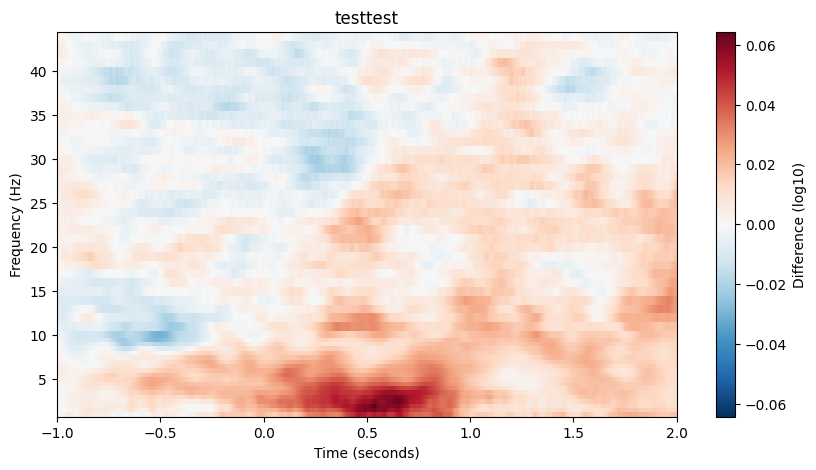

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import mne


def load_h5_file(file_path):
    """
    Load data from an HDF5 file and print the datasets.

    Parameters:
    file_path (str): The path to the HDF5 file.

    Returns:
    dict: A dictionary containing the datasets.
    """
    data = {}
    with h5py.File(file_path, 'r') as hf:
        for key in hf.keys():
            if hf[key].shape == ():  # Check if the dataset is a scalar
                value = hf[key][()]
                if isinstance(value, bytes):  # Check if the value is a byte string
                    value = value.decode('utf-8')
                data[key] = value
            else:
                data[key] = hf[key][:]
                if isinstance(data[key], np.ndarray) and data[key].dtype.type is np.bytes_:
                    data[key] = data[key].astype(str)
            
    return data


file_path = f'/mnt/data/AdaptiveControl/IBLrawdata/group_level_data/layer6/TFRpermut_LF_BiasRight_BiasLeft_layer6_raw.h5'
data = load_h5_file(file_path)

randomTFRpath = '/mnt/data/AdaptiveControl/IBLrawdata/TF_data/22609d51-0a6a-425d-a3ef-eeb43a9ba350/powerLF_raw_VISp6a_381.h5'
randomTFR = mne.time_frequency.read_tfrs(randomTFRpath)
timearray = randomTFR[0].times
freqarray = randomTFR[0].freqs

diff_data= data['all_subjects_averageTFR']
clusters= [data['clusters'][i] for i in range(len(data['clusters']))]
cluster_p_values = data['cluster_p_values']



# Create a mask of significant clusters
significant_mask = np.zeros_like(diff_data, dtype=bool)
for i, cluster in enumerate(clusters):
    if cluster_p_values[i] < 0.05:
        significant_mask |= cluster.astype(bool)

        
# Calculate time and frequency edges
time_edges = np.concatenate(([timearray[0] - (timearray[1] - timearray[0]) / 2],
                                (timearray[:-1] + timearray[1:]) / 2,
                                [timearray[-1] + (timearray[-1] - timearray[-2]) / 2]))
freq_edges = np.concatenate(([freqarray[0] - (freqarray[1] - freqarray[0]) / 2],
                                (freqarray[:-1] + freqarray[1:]) / 2,
                                [freqarray[-1] + (freqarray[-1] - freqarray[-2]) / 2]))

# Plot the difference
plt.figure(figsize=(10, 5))
plt.pcolormesh(time_edges, freq_edges, diff_data, cmap='RdBu_r',
                vmin=-np.max(np.abs(diff_data)), vmax=np.max(np.abs(diff_data)))
plt.colorbar(label='Difference (log10)')
plt.title(f'testtest')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')

# Apply shading to non-significant areas
non_significant_mask = ~significant_mask
plt.pcolormesh(time_edges, freq_edges, np.ma.masked_where(non_significant_mask == False, non_significant_mask),
                cmap='gray', alpha=0.6)
plt.show()



